In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning
import tensorflow as tf
from tf_agents.environments import py_environment, tf_py_environment, suite_gym, suite_atari
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.specs import array_spec
from tf_agents.utils import common
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts


import warnings
warnings.filterwarnings('ignore')

In [2]:
loaded_model = tf.keras.models.load_model("neural_network_model.h5")

In [3]:
class RPSLSEnvironment(py_environment.PyEnvironment):
    def __init__(self, model):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=4, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(4,), dtype=np.int32, minimum=0, maximum=4, name='observation')
        self._state = np.zeros(4, dtype=np.int32)
        self._episode_ended = False
        self.model = model
        self.num_moves = 0
        self.max_moves = 100  # Set your own maximum number of moves

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros(4, dtype=np.int32)
        self._episode_ended = False
        self.num_moves = 0
        return ts.restart(self._state)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()

        # Update the state with the new action
        self._state = np.roll(self._state, shift=-1)
        self._state[-1] = action
        self.num_moves += 1

        # Determine the reward
        if len(self._state) < 2:
            reward = -0.1  # Small negative reward for each move
        else:
            player_move = action
            computer_move = self._state[-2]
            if player_move == computer_move:
                reward = 0  # Tie
            elif (player_move - computer_move) % 5 in [1, 3]:
                reward = 1  # Player wins
            else:
                reward = -1  # Player loses

        # Check if the game is done
        self._episode_ended = self.num_moves >= self.max_moves

        if self._episode_ended:
            return ts.termination(self._state, reward)
        else:
            return ts.transition(self._state, reward=reward, discount=1.0)

    def get_next_move(self, state):
        # Predict the Q-values for the given state
        q_values = self.model.predict(state.reshape(1, -1))[0]
        # Choose the action with the highest Q-value
        next_move = np.argmax(q_values)
        return next_move

    def get_action(self, epsilon=0.1):
        # Use the model to get the next action
        if np.random.rand() < epsilon:
            return np.random.choice(5)  # Choose a random action with probability epsilon
        else:
            return self.get_next_move(self._state)  # Choose the action with the highest predicted Q-value with probability 1-epsilon

# Initialize the environment with your loaded model
env = RPSLSEnvironment(loaded_model)

In [4]:
# Define the number of episodes to train for, an episode is a complete game
num_episodes = 1000

# Define the discount factor, determines the importance of future rewards
gamma = 0.9

# define intial and minimum epsilon, which is the probability of choosing a random action
# Define the initial epsilon
epsilon = 1.0

# Define the minimum epsilon
min_epsilon = 0.01

# Define the epsilon decay rate, which determines how quickly epsilon decreases
epsilon_decay = 0.995

# Initialize the list to store rewards
rewards = []

# choose optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for i_episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    for t in range(env.max_moves):
        action = env.get_action(epsilon)
        next_state, reward, done, _ = env.step(action)

        if done:
            target = reward
        else:
            next_state_array = np.array(next_state.observation[0])
            next_state_q_values = loaded_model.predict(next_state_array.reshape(1, -1))
            target = reward + gamma * np.max(next_state_q_values)

        state_array = np.array(state.observation[0])
        q_values = loaded_model.predict(state_array.reshape(1, -1))
        q_values[0][action] = target

        # Train the model using custom loss function
        with tf.GradientTape() as tape:
            predicted_q_values = loaded_model(state_array.reshape(1, -1))
            loss = tf.keras.losses.mean_squared_error(q_values, predicted_q_values)
        gradients = tape.gradient(loss, loaded_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, loaded_model.trainable_variables))

        state = next_state
        episode_reward += reward

        if done:
            break

    epsilon = max(min_epsilon, epsilon_decay * epsilon)
    rewards.append(episode_reward)

    if i_episode % 100 == 0:
        print(f"Episode {i_episode}: {np.mean(rewards[-100:])}")


1/1 [==============================] - 1s 837ms/step
Episode 0: 1.0
1/1 [==============================] - 0s 21ms/step
Episode 100: 0.1
1/1 [==============================] - 0s 19ms/step
Episode 200: 0.5
1/1 [==============================] - 0s 16ms/step
Episode 300: 0.65
1/1 [==============================] - 0s 21ms/step
Episode 400: 0.77
1/1 [==============================] - 0s 17ms/step
Episode 500: 0.97
1/1 [==============================] - 0s 17ms/step
Episode 600: 0.97
1/1 [==============================] - 0s 16ms/step
Episode 700: 0.91
1/1 [==============================] - 0s 15ms/step
Episode 800: 0.98
1/1 [==============================] - 0s 17ms/step
Episode 900: 0.96
1/1 [==============================] - 0s 19ms/step


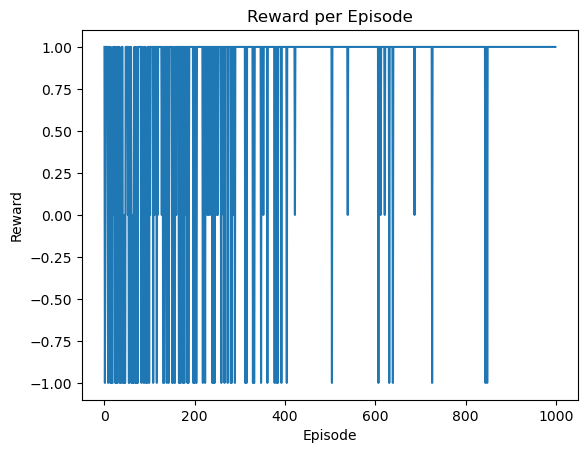

In [5]:
# Plot the rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

In [6]:
# Define the number of test episodes
num_test_episodes = 100

# Initialize the list to store test rewards
test_rewards = []

for i_episode in range(num_test_episodes):
    state = env.reset()
    episode_reward = 0

    for t in range(env.max_moves):
        # Get the action with the highest Q-value
        action = env.get_next_move(state.observation)
        next_state, reward, done, _ = env.step(action)

        state = next_state
        episode_reward += reward

        if done:
            break

    test_rewards.append(episode_reward)

print(f"Average test reward: {np.mean(test_rewards)}")

1/1 [==============================] - 0s 27ms/step
Average test reward: 1.0
